# How can remote sensing be used to monitor active storage sites?

In my third subquestion, I use data from Miocic et al. (2016) to evaluate remote sensing data that is collected at both secure and insecure carbon storage basins.

# Import Necessary Packages

In [1]:
import pandas as pd
import numpy as np
from plotnine import *
import geopandas as gpd
import leafmap.maplibregl as leafmap
from pystac_client import Client
from shapely.geometry import GeometryCollection
import odc.stac
import rioxarray
from exactextract import exact_extract
from shapely.geometry import Point
import json
import matplotlib.pyplot as plt

# Dataframe Creation 
## Read in Miocic et al. (2016)

I use pandas to read in the data and create **miocic_locations**. It is important to note that this data was previosuly downloaded separately from **miocic_database** because it is located on a separtate tab within the .xlsx file, and is therefore read in as a separate .csv.

In [2]:
miocic_locations = pd.read_csv('miocic_locations.csv')

In [3]:
miocic_locations

,Lat,Long,Leakage,Fault bound/sealed?
0,32.406944,-89.839722,No,NaN
1,34.261111,-109.164722,Yes,Yes
2,42.454722,-110.248056,No,No
3,37.699722,-105.196944,No,Yes
4,39.519167,-110.633611,Yes,Yes
...,...,...,...,...
56,27.510000,68.710000,No,NaN
57,13.100000,96.520000,No,NaN
58,20.000000,112.000000,No,NaN
59,18.370000,107.950000,No,NaN


**miocic_locations** contains location information for the sites and can be joined to the **miocic_database** basin information using the index. It also contains leakage information which is used to represent site security.
## Create geo dataframe

Pandas does not handle geospatial data, so I convert the dataframe to a pandas geodataframe **miocic_gdf** using the Lat and Long columns to create a geometry column.

In [4]:
miocic_locations['Leakage'].unique()

array(['No', 'Yes', 'Inconclusive', 'No '], dtype=object)

In [5]:
miocic_locations['Leakage'] = miocic_locations['Leakage'].str.strip()

In [6]:
miocic_locations['Leakage'].unique()

array(['No', 'Yes', 'Inconclusive'], dtype=object)

In [7]:
miocic_gdf = gpd.GeoDataFrame(miocic_locations, 
                       geometry=  gpd.points_from_xy(miocic_locations['Long'], #longitude x axis first
                                                     miocic_locations['Lat']), #latitude y axis second
                       crs = 'EPSG:4326')

In [8]:
miocic_gdf

,Lat,Long,Leakage,Fault bound/sealed?,geometry
0,32.406944,-89.839722,No,NaN,POINT (-89.83972 32.40694)
1,34.261111,-109.164722,Yes,Yes,POINT (-109.16472 34.26111)
2,42.454722,-110.248056,No,No,POINT (-110.24806 42.45472)
3,37.699722,-105.196944,No,Yes,POINT (-105.19694 37.69972)
4,39.519167,-110.633611,Yes,Yes,POINT (-110.63361 39.51917)
...,...,...,...,...,...
56,27.510000,68.710000,No,NaN,POINT (68.71000 27.51000)
57,13.100000,96.520000,No,NaN,POINT (96.52000 13.10000)
58,20.000000,112.000000,No,NaN,POINT (112.00000 20.00000)
59,18.370000,107.950000,No,NaN,POINT (107.95000 18.37000)


### Create buffered geo dataframe

Now that I have the geodataframe and point geometries, I expand this to create a buffer around each point geometry. This way, I capture more satellite data information at each site. This is important to get a better understanding of each site and its greenness, which might be hard to interpret at a single point, especially if the satellite's spatial resolution covers more than a single coordinate. This is also important to get enough images within the corresponding date ranges after filtering for clouds. 

I use a radius of 15m in congruence with Chen el al.(2019).

To accomplish this, I create a copy of the geodataframe named **buffer** and convert it to a different coordinate reference system, '3857'. In this new CRS, I can create a buffered geometry at the 15m radius as the geometry. I have to convert to a different CRS to correctly implement the buffer since the radius is expressed in meters. Afterwards, convert back to the standard CRS.

In [9]:
radius = 15
buffer = miocic_gdf.copy()
buffer= buffer.to_crs(3857)
buffer['geometry']= buffer.geometry.buffer(radius)
buffer = buffer.to_crs(4326)

In [10]:
buffer

,Lat,Long,Leakage,Fault bound/sealed?,geometry
0,32.406944,-89.839722,No,NaN,"POLYGON ((-89.83959 32.40694, -89.83959 32.406..."
1,34.261111,-109.164722,Yes,Yes,"POLYGON ((-109.16459 34.26111, -109.16459 34.2..."
2,42.454722,-110.248056,No,No,"POLYGON ((-110.24792 42.45472, -110.24792 42.4..."
3,37.699722,-105.196944,No,Yes,"POLYGON ((-105.19681 37.69972, -105.19681 37.6..."
4,39.519167,-110.633611,Yes,Yes,"POLYGON ((-110.63348 39.51917, -110.63348 39.5..."
...,...,...,...,...,...
56,27.510000,68.710000,No,NaN,"POLYGON ((68.71013 27.51000, 68.71013 27.50999..."
57,13.100000,96.520000,No,NaN,"POLYGON ((96.52013 13.10000, 96.52013 13.09999..."
58,20.000000,112.000000,No,NaN,"POLYGON ((112.00013 20.00000, 112.00013 19.999..."
59,18.370000,107.950000,No,NaN,"POLYGON ((107.95013 18.37000, 107.95013 18.369..."


In [12]:
def NDVI_site(site):
    items = (
      Client.
      open("https://earth-search.aws.element84.com/v1").
      search(
        collections = ['sentinel-2-l2a'],
        intersects=site.geometry.__geo_interface__,
        datetime = f"2025-01-01/2026-01-01",
        query={"eo:cloud_cover": {"lt": 20}}).
      item_collection()  )   
    
    data = odc.stac.load(
        items,
        bands=["nir08", "red"],
        intersects=site.geometry.__geo_interface__,
        resolution=20, 
        groupby="solar_day",
        chunks = {} )
    
    if len(items) < 1:
        return None
        
    ndvi = (
        ((data.nir08 - data.red) / (data.red + data.nir08)) 
        .median("time", keep_attrs=True)
    )

    ndvi = ndvi.where(ndvi < 1).compute()
    mean_ndvi_area = ndvi.mean().item()
    return mean_ndvi_area

In [13]:
site = buffer.iloc[0, :]
NDVI_site(site)

0.38208718701119093

In [10]:
NDVI_15m = []
num=1
for id, site in buffer.iterrows():
    NDVI_15m.append(NDVI_site(site))
    print(f'{num} complete')
    num = num + 1

1 complete
2 complete
3 complete
4 complete
5 complete
6 complete
7 complete
8 complete
9 complete
10 complete
11 complete
12 complete
13 complete
14 complete
15 complete
16 complete
17 complete
18 complete
19 complete
20 complete
21 complete
22 complete
23 complete
24 complete
25 complete
26 complete
27 complete
28 complete
29 complete
30 complete
31 complete
32 complete
33 complete
34 complete
35 complete
36 complete
37 complete
38 complete
39 complete
40 complete
41 complete
42 complete
43 complete
44 complete
45 complete
46 complete
47 complete
48 complete
49 complete
50 complete
51 complete
52 complete
53 complete
54 complete
55 complete
56 complete
57 complete
58 complete
59 complete
60 complete
61 complete


In [11]:
NDVI_15m_df.to_csv('miocic_NDVI15m.csv')

NameError: name 'NDVI_15m_df' is not defined

In [12]:
miocic_NDVI15m = pd.read_csv('miocic_NDVI15m.csv')

In [13]:
miocic_NDVI15m

,Unnamed: 0,ndvi
0,0,0.382087
1,1,0.128419
2,2,0.159029
3,3,0.408474
4,4,0.082036
...,...,...
56,56,0.125757
57,57,NaN
58,58,NaN
59,59,0.091355


In [14]:
sum(miocic_NDVI15m['ndvi'].isna())

11

In [15]:
merged = buffer.merge(miocic_NDVI15m, left_index=True, right_index=True)[['Leakage', 'ndvi']].dropna()
merged.head()

,Leakage,ndvi
0,No,0.382087
1,Yes,0.128419
2,No,0.159029
3,No,0.408474
4,Yes,0.082036


In [16]:
stats = (merged
 .groupby('Leakage').mean())
stats

,ndvi
Leakage,
Inconclusive,0.770967
No,0.366113
Yes,0.389461


In [17]:
stats.reset_index(inplace=True)
stats= stats[stats['Leakage'] != 'Inconclusive']

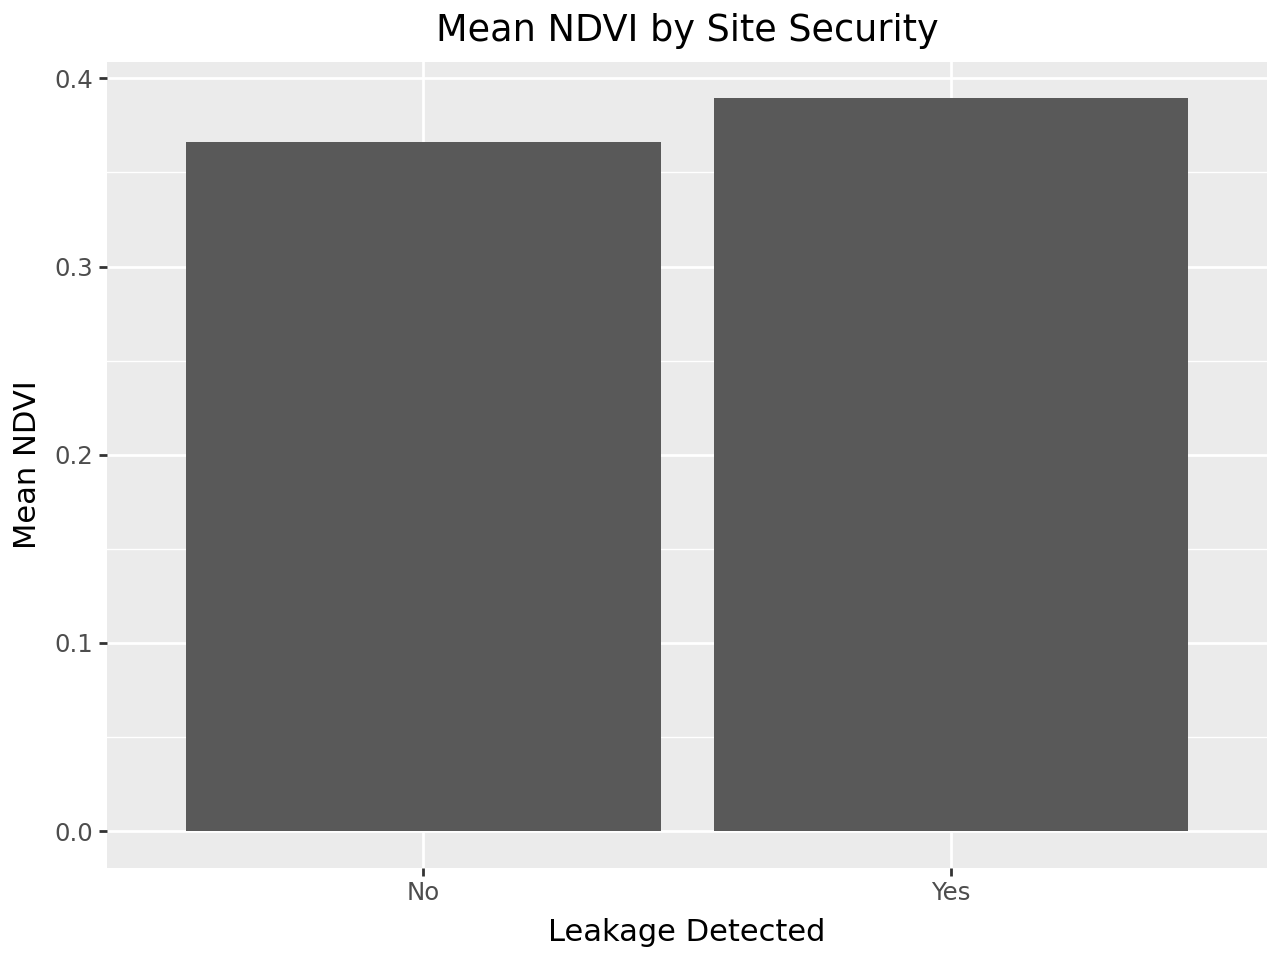

In [18]:
(ggplot(stats, aes(x='Leakage', y= 'ndvi')) 
 + geom_bar(stat='identity')  # use the values directly
 + labs(title='Mean NDVI by Site Security',
        x='Leakage Detected',
        y='Mean NDVI'))

In [21]:
site_color = {
    "No": "#1f77b4",         # blue
    "Yes": "#d62728",                 # red
    "Inconclusive": "#9467bd",  # purple 
}
site_paint = {
    "circle-color": ["get", "basin_security_color"],
    "circle-radius": 6,      
    "circle-opacity": 0.7,
    "circle-stroke-color": "#000000",
    "circle-stroke-width": 0.5}

In [22]:
miocic_gdf["basin_security_color"] = miocic_gdf[
    "Leakage"].map(site_color).fillna("#999999")

In [23]:
miocic_gdf["basin_security_color"]

0     #1f77b4
1     #d62728
2     #1f77b4
3     #1f77b4
4     #d62728
       ...   
56    #1f77b4
57    #1f77b4
58    #1f77b4
59    #1f77b4
60    #1f77b4
Name: basin_security_color, Length: 61, dtype: object

In [24]:
m = leafmap.Map(style = "positron")
m.add_gdf(miocic_gdf, 
          layer_type = 'circle',
          paint = site_paint,
         name = 'Leakage Detected?')
m

Html(children=[Map(calls=[['addControl', ('NavigationControl', {'showCompass': True, 'showZoom': True, 'visual…

6-9 DO NOT DO WHOLE YEAR

15m buffer vs 45m (3x)